<a href="https://colab.research.google.com/github/Rompil/hands-on/blob/master/PySpark_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache-mirror.rbc.ru/pub/apache/spark/spark-2.4.1/spark-2.4.1-bin-hadoop2.7.tgz
!tar xvzf spark-2.4.1-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.1-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.master("local[*]").getOrCreate()
#sc = SparkContext(appName='MLlibHands_on')

In [0]:
!wget -q http://devdemo.competentum.com/dataset/boston_train.csv


# Практическое введение в PySpark для Data Scientists (Часть 2)
## Обзор модуля PySpark MLlib


Модуль MLlib предназначен для использования уже готовых алгоритмов машинного обучения в прикладных задачах при обработке больших данных. Во многом он схож с Scikit-learn, что делает его легким в освоении и позволяет переносить уже готовые методы обработки данных на платформу Spark.

Для лучшего понимания того, зачем делать определенные этапы потом, мы обсудим задачу машинного обучения  в первом приближении.

Вне зависимости от конкретного выбранного алгоритма анализа данных можно выделить схожие этапы:


*   Загрузка и отчистка данных.
*   Извлечение признаков (фич)
*   Тренировка модели
*   Оценка целевых показателей

Эти этапы могут повторяться неоднократно в процессе настройки гиперпараметров модели.

В Spark такой подход унифицировали и сосокупность таких этапов упаковали в **Pipeline**.
Каждый этап в Pipeline представляет из себя либо Transformer, либо Estimator, либо Evaluator.
При этом, Pipeline может содержать произвольное количество таких унафицированных этапов, каждый из которых может быть соединен с другим и выступать как източником , так и потребителем для других этапов.
Каждый из таких этапов надо рассмотреть подробнее.





**Transformer:** 


*   Используется на этапе препроцессинга
*   Преобразует данные в необходимый формат для далдьнейшей обработки
*   Обрабатывает по столбцам столбец на входе -> столбец на выходе

Примеры Transformers:
          

*   Нормализация - приведение значений к диапазону от 0 до 1 или к стандартному распределению.
*   Токенизация - замена слов числами
*   Замена категориальных признаков на числовые

Обычно такогого рода преоразования вызывают метод .transform(), на входе и на выходе dataframe.







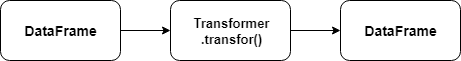

**Estimator:**


*   Чаще всего это обучающие алгоритмы, которые тренеруются на данных
*   Возвращают на выходе модель алгоритма, у которой можно вызвать .transform(), т.е. transformer

Пример Estimator:

>LogisticRegresion.fit(...)  $\longrightarrow$ LogisticRegressionModel.transform()



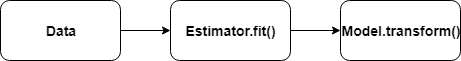

**Evaluator:**



*   Оценивает качество модели на основе определенных параметров: ROC, RMSE
*   Учавствует в автоматическом тюнинге гиперпараметров модели 
*   Позволяет сравнивать качество моделей и выбрать лучшие

Пример Evaluator:

> BinaryClassificationEvaluator

>CrossValidator





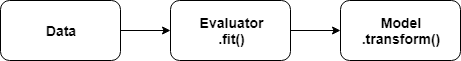

В совокупности такие этапы работы с данными и формируют **Pipeline**

Pipeline  

*   Используется для представления потока обработки данных в ML   
*   Состоит из отдельных этапов, которае легко контроллировать.
*   Эти этапы унифицированы и легко взаимозаменяемы.
*   Сам Pipeline является экземпляром типа Estimator и для него модно вызвать метод .fit()
*   Pipeline можно как сохранить во внешней памяти, так  и загрузить из нее для повторного использования.



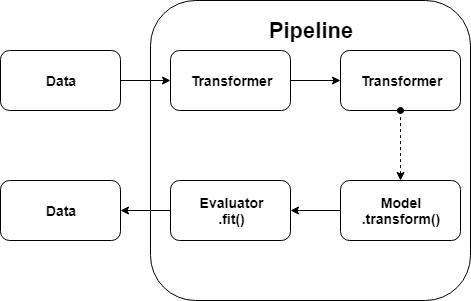

##Основные модули MLlib

Если разбираться в MLlib детальнее, то можно выделить отдельные группы подмодулей, каждый из которых предназначен для решения своего рода задач:


*   ML Algorithms - Все основные распространенные алгоритмы машинного обучения которые встречаются на практике: линейная регрессия, логистическая регрессия, клатеризация и т.д.
*   Featurization - Методы преобразования и извлечения признаков, уменьшения размерности и формирования выборки. 
*   Pipelines - инструменты формирования, оценивания и настройки (тюнинга) ML Pipeline'ов
*   Persistance - средства сохранения и загрузки алгоритмов, моделей и целых Pipeline'ов
*   Utilities - Все необходимое, связанное с линейной алгеброй, статистикой и вероятностью.



Перед тем как непосредственно начать работать с MLlib надо познакомиться с основными типами данных, с которыми придется иметь дело в примерах.



**Vector**

Векторы в Spark могут задаваться двумя способами:


*   "Плотный" (Dense) вектор, элементы которого задаются перечислением. Совместим с array из  numpy.
*   "Разряженный" (Sparse) вектор, значения в нем задаются по индексу.




In [0]:
from numpy import array
from pyspark.ml.linalg import Vectors

denseVec1 = array([1.0, 2.0, 3.0])
denseVec2 = Vectors.dense([1.0, 2.0, 3.0])

sparseVec1 = Vectors.sparse(4, {0:1.0, 2:2.0})
sparseVec2 = Vectors.sparse(4, [0, 2], [1.0, 2.0])

Естественно, что имея массивы с числовыми данными, мы можем производить различные манипуляции для выявления зависимостей.

Например, посчитать коэффициенты корреляции для 4 векторов. 

In [0]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation

data = [(Vectors.sparse(4, [(0, 1.0), (3, -2.0)]),),
        (Vectors.dense([4.0, 5.0, 0.0, 3.0]),),
        (Vectors.dense([6.0, 7.0, 0.0, 8.0]),),
        (Vectors.sparse(4, [(0, 9.0), (3, 1.0)]),)]
df = spark.createDataFrame(data, ["features"])

r1 = Correlation.corr(df, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

Pearson correlation matrix:
DenseMatrix([[1.        , 0.05564149,        nan, 0.40047142],
             [0.05564149, 1.        ,        nan, 0.91359586],
             [       nan,        nan, 1.        ,        nan],
             [0.40047142, 0.91359586,        nan, 1.        ]])


Или базовые статистики для DataFrame с учетом веса каждой строки:

In [0]:
from pyspark.ml.stat import Summarizer
from pyspark.sql import Row

df = spark.sparkContext.parallelize([Row(weight=0.0, features=Vectors.dense(1.0, 1.0, 1.0)),
                                     Row(weight=1.0, features=Vectors.dense(1.0, 2.0, 3.0))]).toDF()

# create summarizer for multiple metrics "mean" and "count"
summarizer = Summarizer.metrics("mean", "count")

# compute statistics for multiple metrics with weight
df.select(summarizer.summary(df.features, df.weight)).show(truncate=False)

# compute statistics for multiple metrics without weight
df.select(summarizer.summary(df.features)).show(truncate=False)

# compute statistics for single metric "mean" with weight
df.select(Summarizer.mean(df.features, df.weight)).show(truncate=False)

# compute statistics for single metric "mean" without weight
df.select(Summarizer.mean(df.features)).show(truncate=False)

+-----------------------------------+
|aggregate_metrics(features, weight)|
+-----------------------------------+
|[[1.0,2.0,3.0], 1]                 |
+-----------------------------------+

+--------------------------------+
|aggregate_metrics(features, 1.0)|
+--------------------------------+
|[[1.0,1.5,2.0], 2]              |
+--------------------------------+

+--------------+
|mean(features)|
+--------------+
|[1.0,2.0,3.0] |
+--------------+

+--------------+
|mean(features)|
+--------------+
|[1.0,1.5,2.0] |
+--------------+



## Практические примеры применения MLlib

Ближе познакомиться с возможностями данной библиотеки и закрепить навыки лучше на практических примерах. Одним из таких примеров была выбрана задача Линейной регрессии и Задача классификации на данных приближенных к настоящим.

### Линейная регрессия



В этой задаче надо будет предсказать стоимость недвижимосте в окрестностях Бостона на основе существующих данных.
Данные взяты с конкурса [Kaggle competition: Housing Values in Suburbs of Boston](https://www.kaggle.com/c/boston-housing/data).
Данные содержат следующие столбцы:

* crim - уровень преступности на душу населения по городам .

* zn - доля жилой земли, зонированной под участки более 25 000 кв. Футов.

* indus - доля неторговых площадей на город, от слова INDUSTRIAL

* chas- фиктивная переменная реки Чарльз (= 1, если тракт ограничивает реку; 0 в противном случае).

* nox - концентрация оксидов азота (частей на 10 млн.).

* rm - среднее количество комнат на одно жилище.

* age - доля домовладельцев, построенных до 1940 года.

* dis - взвешенное среднее расстояние до пяти бостонских центров занятости.

* rad - индекс доступности к радиальным магистралям.

* tax - полная стоимость налога на недвижимость за 10 000 долларов США.

* ptratio - соотношение учеников и учителей по городам (pupil-teacher ration).

* black - 1000 (БК - 0,63) ², где Бк - доля чернокожих по городам.

* lstat - более низкий статус населения (в процентах).

* medv - средняя (медиана) стоимость домов, занимаемых владельцами, в $ 1000. Это целевая переменная.

По представленным данным нужно предложить модель, которая предскажет медианную стоимость домовладения в заданной области.

#### Загрузка данных

In [37]:
house_df = spark.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('boston_train.csv')
house_df.take(1)

[Row(ID=1, crim=0.00632, zn=18.0, indus=2.31, chas=0, nox=0.538, rm=6.575, age=65.2, dis=4.09, rad=1, tax=296, ptratio=15.3, black=396.9, lstat=4.98, medv=24.0)]

#### Исследование содержимого.

Чтобы не читаь данные каждый раз из файла нам нужно их закэшировать.

In [38]:
house_df.cache()
house_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- black: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



Часто для наглядности и привычного представления импользуют такой подход:

In [39]:
house_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
ID,333,250.95195195195194,147.8594378018597,1,506
crim,333,3.3603414714714708,7.352271836781104,0.00632,73.5341
zn,333,10.68918918918919,22.674761796618217,0.0,100.0
indus,333,11.29348348348346,6.998123104477312,0.74,27.74
chas,333,0.06006006006006006,0.2379556428164483,0,1
nox,333,0.557144144144145,0.11495450830289312,0.385,0.871
rm,333,6.265618618618616,0.7039515757334471,3.561,8.725
age,333,68.22642642642641,28.13334360562338,6.0,100.0
dis,333,3.7099336336336335,1.9811230514407001,1.1296,10.7103


Матрица рассеяния является отличным способом приблизительного определения, имеем ли мы линейную корреляцию между несколькими независимыми переменными, но нужно предупредить, что так делать не всегда стоит из-за размера pandas.DataFrame- он может не поместиться в памяти машины.


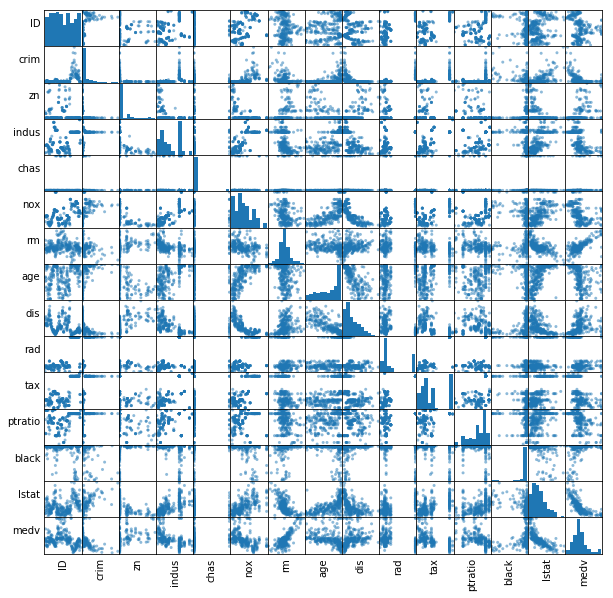

In [42]:
import pandas as pd
numeric_features = [t[0] for t in house_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = house_df.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

На глаз зависимость не столь очевидна.

In [43]:
from pyspark.sql.types import StringType
for i in house_df.columns:
    if not( isinstance(house_df.select(i).take(1)[0][0], StringType)):
        print( "Correlation to 'medv' for ", i, house_df.stat.corr('medv',i))

Correlation to 'medv' for  ID -0.22169418651611697
Correlation to 'medv' for  crim -0.4074543235732598
Correlation to 'medv' for  zn 0.34484197569664277
Correlation to 'medv' for  indus -0.47393197065920345
Correlation to 'medv' for  chas 0.20438998859918733
Correlation to 'medv' for  nox -0.4130541519920783
Correlation to 'medv' for  rm 0.6895980892872156
Correlation to 'medv' for  age -0.35888827406190227
Correlation to 'medv' for  dis 0.24942226829396397
Correlation to 'medv' for  rad -0.3522508242456341
Correlation to 'medv' for  tax -0.44807769440070433
Correlation to 'medv' for  ptratio -0.48137595552491735
Correlation to 'medv' for  black 0.33665955532155767
Correlation to 'medv' for  lstat -0.7386000348786346
Correlation to 'medv' for  medv 1.0


Коэффициент корреляции варьируется от –1 до 1. Когда он близок к 1, это означает, что существует сильная положительная корреляция; например, среднее значение имеет тенденцию увеличиваться, когда количество комнат увеличивается. Когда коэффициент близок к –1, это означает, что существует сильная отрицательная корреляция; среднее значение имеет тенденцию уменьшаться, когда процент населения с более низким статусом повышается. Наконец, коэффициенты, близкие к нулю, означают, что нет линейной корреляции.

Переходим непосредственно к основным этапам машинного обучения. Начнем с подготовки данных.
Нам  необходимо отдельные значения в столбцах объединить в один вектор признаков. Это делает VectorAssembler - объединяет числовые значения из для каждой строки в  "плотный" вектор из которых формирует новый столбец.

In [45]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat'], outputCol = 'features')
vhouse_df = vectorAssembler.transform(house_df)
vhouse_df = vhouse_df.select(['features', 'medv'])
vhouse_df.show(3)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.03237,0.0,2.18...|33.4|
+--------------------+----+
only showing top 3 rows



Следующим этапом будет разделение данных на тренировочную и валидационную выборку.

In [0]:
splits = vhouse_df.randomSplit([0.7, 0.3]) # 70% - training, 30% - validation
train_df = splits[0]
test_df = splits[1]

На подготовленных данным уже можно обучать *линейную модель*.

In [49]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='medv', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.0,0.024304945001369944,0.0,4.448961723698286,-4.892212035340447,3.85306952802328,0.0,-1.171103003344825,0.02578612079737042,0.0,-0.5692131127483666,0.011135619535822231,-0.698420110549228]
Intercept: 20.227964681475985


Полученные параметры модели можно оценить по числовым показателям: MRSE, R^2

1.   RMSE - корень из среднеквадратичной ошибки 
2.   $R^2$ - коэффициент детерминации (0 - 1) 



In [50]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 5.123383
r2: 0.720400


RMSE измеряет разницу между прогнозируемыми значениями по модели и фактическими значениями.
Неплохо б ывзглянуть еще на некоторые значения описывающие качество нашей модели.

In [51]:
train_df.describe().show()

+-------+------------------+
|summary|              medv|
+-------+------------------+
|  count|               229|
|   mean|22.937991266375555|
| stddev| 9.710434674170203|
|    min|               5.0|
|    max|              50.0|
+-------+------------------+



Коэффициент детерминации ($R^2$) получился ~72%, что не так уж плохо. Это говорит о том, чот 72% случаев объясняются нашей линейной моделью. Но может так случится, что на валмдационных данных наш результат окажется несколько ниже.

In [54]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","medv","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="medv",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
| 30.33858158393237|32.7|[0.01301,35.0,1.5...|
|30.168132635710393|29.1|[0.01439,60.0,2.9...|
| 23.43557543024113|33.0|[0.01951,17.5,1.3...|
| 24.81283736644643|21.6|[0.02731,0.0,7.07...|
|30.091886589882506|30.8|[0.02763,75.0,2.9...|
+------------------+----+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.687131


In [55]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 4.39437


Хотя RMSE стал несколько меньше, но $R^2$ снизился, что говорит об ухудшении предсказаний на новых данных ( не участвовавших в обучении модели).

In [56]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 11
objectiveHistory: [0.5, 0.4364253875652964, 0.25583355087945764, 0.22914160179069598, 0.1939172862255533, 0.18679415492709053, 0.18485728176729538, 0.1833341511722882, 0.18067966165007415, 0.18048886866060176, 0.1793081077059195]
+--------------------+
|           residuals|
+--------------------+
|  -6.835985218540259|
|   2.758839873133862|
| -3.9322025919034473|
|   6.220324092023368|
|   2.590149209452054|
|   1.288678263708647|
| -1.9340251103494452|
|   6.979636398137373|
|   2.233711095646953|
| -2.0482406599253338|
|    2.01144453762479|
|  10.463581537156728|
|-0.01662366289132322|
|   0.445008030991886|
|  -8.330098014816954|
| -3.9000308852575536|
| -3.0964421309981027|
|  3.7741809340755736|
| -1.9171767894892753|
|  1.5209548801056698|
+--------------------+
only showing top 20 rows



Информация о полученной модели описывает количество итерации проведенных для обучения (numIterations), соответсвующие веса для фич  и поведение модели на каждой итерации вычисленное по формуле:  $L = 1/2n||\sum_i w_i(x_i - \bar{x_i}) / \hat{x_i} - (y - \bar{y}) / \hat{y}||^2 + regTerms$

Построим предсказание на основе полученной модели.

In [57]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","medv","features").show()

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
| 30.33858158393237|32.7|[0.01301,35.0,1.5...|
|30.168132635710393|29.1|[0.01439,60.0,2.9...|
| 23.43557543024113|33.0|[0.01951,17.5,1.3...|
| 24.81283736644643|21.6|[0.02731,0.0,7.07...|
|30.091886589882506|30.8|[0.02763,75.0,2.9...|
| 24.58121288217513|26.6|[0.02899,40.0,1.2...|
|29.322606030549558|31.2|[0.03049,55.0,3.7...|
|20.402019659302425|19.5|[0.03427,0.0,5.19...|
| 38.21431460702516|48.5|[0.0351,95.0,2.68...|
| 30.02673496124785|27.9|[0.03615,80.0,4.9...|
| 32.06303838782549|35.4|[0.03705,20.0,3.3...|
|28.359509054236355|28.0|[0.04113,25.0,4.8...|
|25.249735134863037|20.6|[0.04294,28.0,15....|
|26.760744725093204|23.3|[0.0456,0.0,13.89...|
|25.103081199882332|22.3|[0.0459,52.5,5.32...|
|24.299294704794207|23.9|[0.05059,0.0,4.49...|
| 32.26699510944075|37.2|[0.0578,0.0,2.46,...|
|21.630242847057986|18.7|[0.06151,0.0,5.19...|
|25.608958465

Как известно, линейная регрессия не едиственный метод предсказания числовой величины. Можно применить и другие подходы

### Регрессионные решающие деревья

In [59]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'medv')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 4.33925


Полученный результат незначительно, но  лучше чем у модели линейной регрессии. 

In [60]:
dt_model.featureImportances

SparseVector(13, {0: 0.0342, 4: 0.0118, 5: 0.5964, 6: 0.0021, 7: 0.1304, 8: 0.0084, 9: 0.0041, 10: 0.0146, 12: 0.1981})

In [61]:
house_df.take(1)

[Row(ID=1, crim=0.00632, zn=18.0, indus=2.31, chas=0, nox=0.538, rm=6.575, age=65.2, dis=4.09, rad=1, tax=296, ptratio=15.3, black=396.9, lstat=4.98, medv=24.0)]

Очевидно, что самым весомым фактором в определении медианной цены дома в районе является rm - среднее количество комнат.

### Градиентный бустинг регрессионных деревьев.

In [62]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'medv', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select('prediction', 'medv', 'features').show(5)

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|29.548865159640467|32.7|[0.01301,35.0,1.5...|
|30.325449199546387|29.1|[0.01439,60.0,2.9...|
|34.977713392249996|33.0|[0.01951,17.5,1.3...|
|21.971359571287824|21.6|[0.02731,0.0,7.07...|
| 30.21257314985412|30.8|[0.02763,75.0,2.9...|
+------------------+----+--------------------+
only showing top 5 rows



In [63]:
gbt_evaluator = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 4.05524


Сравнивая результаты трех разлчных алгоритмой решения задачи регрессии (предсказании числа) можно утверждать, что градиентный бустинг с используемыми данными показал наилучший результат.

ПОлезные ссылки:
[Spark github with examples](https://github.com/apache/spark/tree/master/examples/src/main/python/mllib)